# Star Tracking
## Detection in high electrical and luminous noise

Importing the libraries

In [8]:
import matplotlib.pyplot as plt
import cv2
import os
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Installing skimage to compute peak local maxima

In [9]:
!pip install scikit-image


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\anjel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Installing gdown to import the image repositories

In [10]:
!pip install gdown
import gdown


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\anjel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Importing the repository with all the images on which we will work

In [11]:
path = os.getcwd()
print("Your current path", path)
files = os.listdir(path)
print("Files in the current directory:", files)


Your current path c:\Users\anjel\Desktop\Image project\project
Files in the current directory: ['Star Tracking.ipynb', 'Star_images', 'Star_images.zip']


Downloading the repository with the images

In [12]:
file_id = "1yGgAPiegBl9IBCPWQeXmOKNFGsyhw6MW"
url = f"https://drive.google.com/uc?id={file_id}"

output = "Star_images.zip"
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1yGgAPiegBl9IBCPWQeXmOKNFGsyhw6MW
To: c:\Users\anjel\Desktop\Image project\project\Star_images.zip
100%|██████████| 6.10M/6.10M [00:00<00:00, 10.7MB/s]


'Star_images.zip'

Unzipping the repository

In [13]:
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(".")   # "." = cartella corrente
print("The repository has been unzipped successfully.")

The repository has been unzipped successfully.


In [14]:
image_path = "./Star_images"
# Elenco di tutti i file immagine (jpg, png, ecc.)
files = [f for f in os.listdir(image_path) if f.lower().endswith(('.png'))]

print(f"{len(files)} images founded:")
for f in files:
    print("-", f)

8 images founded:
- 0_perfect_annotation.png
- 1 perfect.png
- 2 zero_noise.png
- 3 little_noise.png
- 4 more_noise.png
- 5 dark_current.png
- 6 blur.png
- 7 blurr_current_noise.png


Checking the images we have downloaded

Trying to build the algorithm working on all the images at once, in order to be always sure that the method works in every case

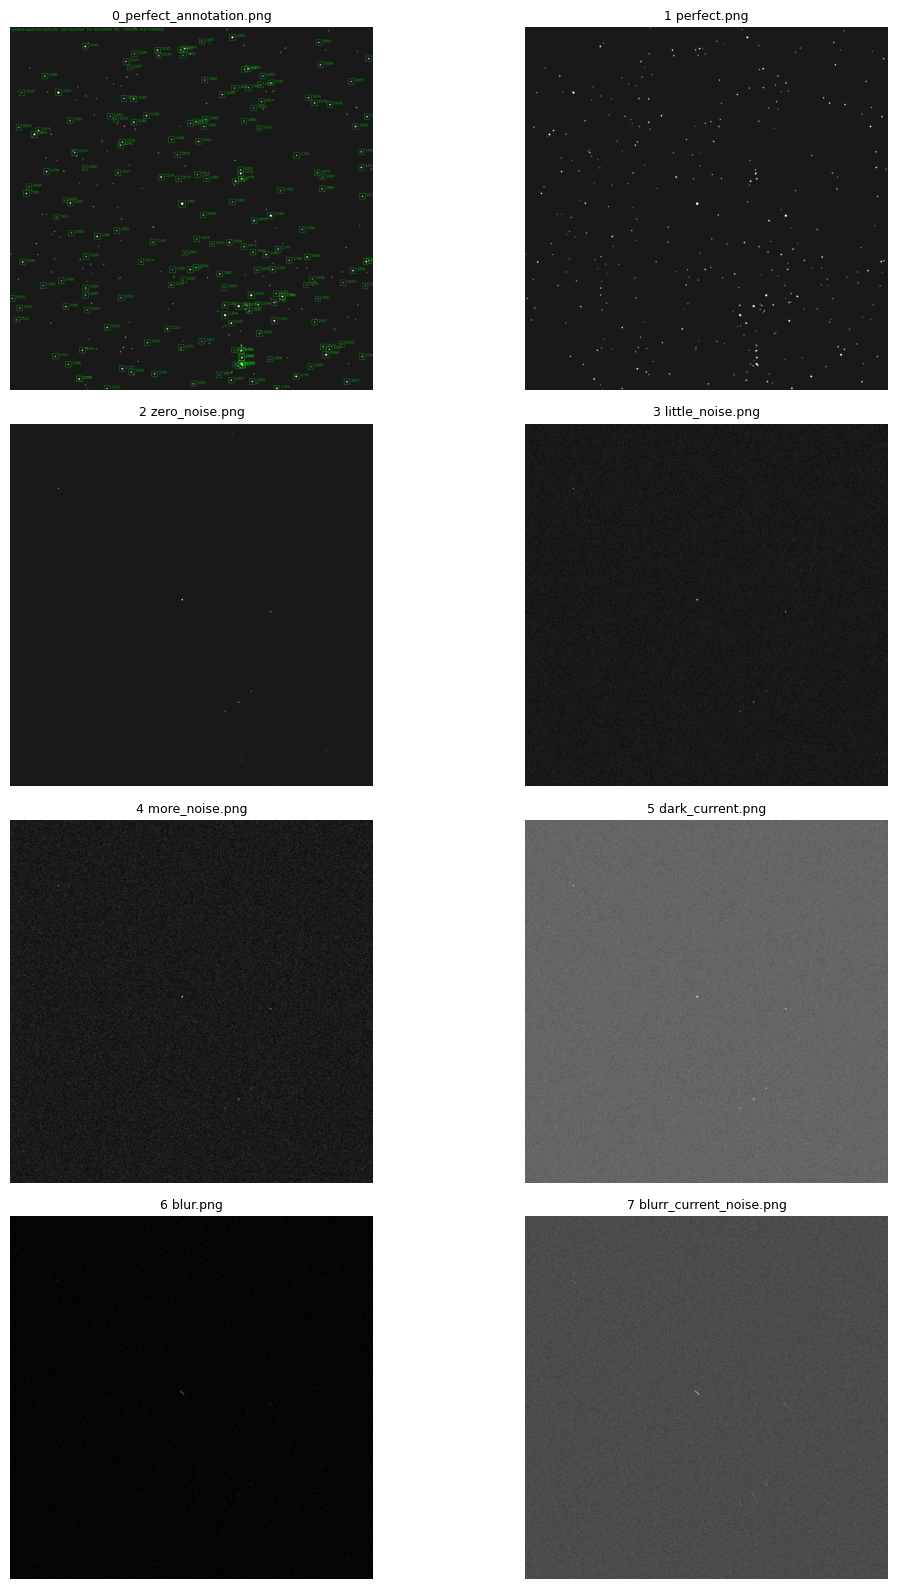

In [15]:
cols = 2  # images per line
rows = math.ceil(len(files) / cols)

plt.figure(figsize=(12, 4 * rows))

for i, file in enumerate(files):
    img = cv2.imread(os.path.join(image_path, file))

    if img is None:
        raise FileNotFoundError(f"Image not found or failed to load: {image_path}")


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.title(file, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


We first work with a simple grey level analisis

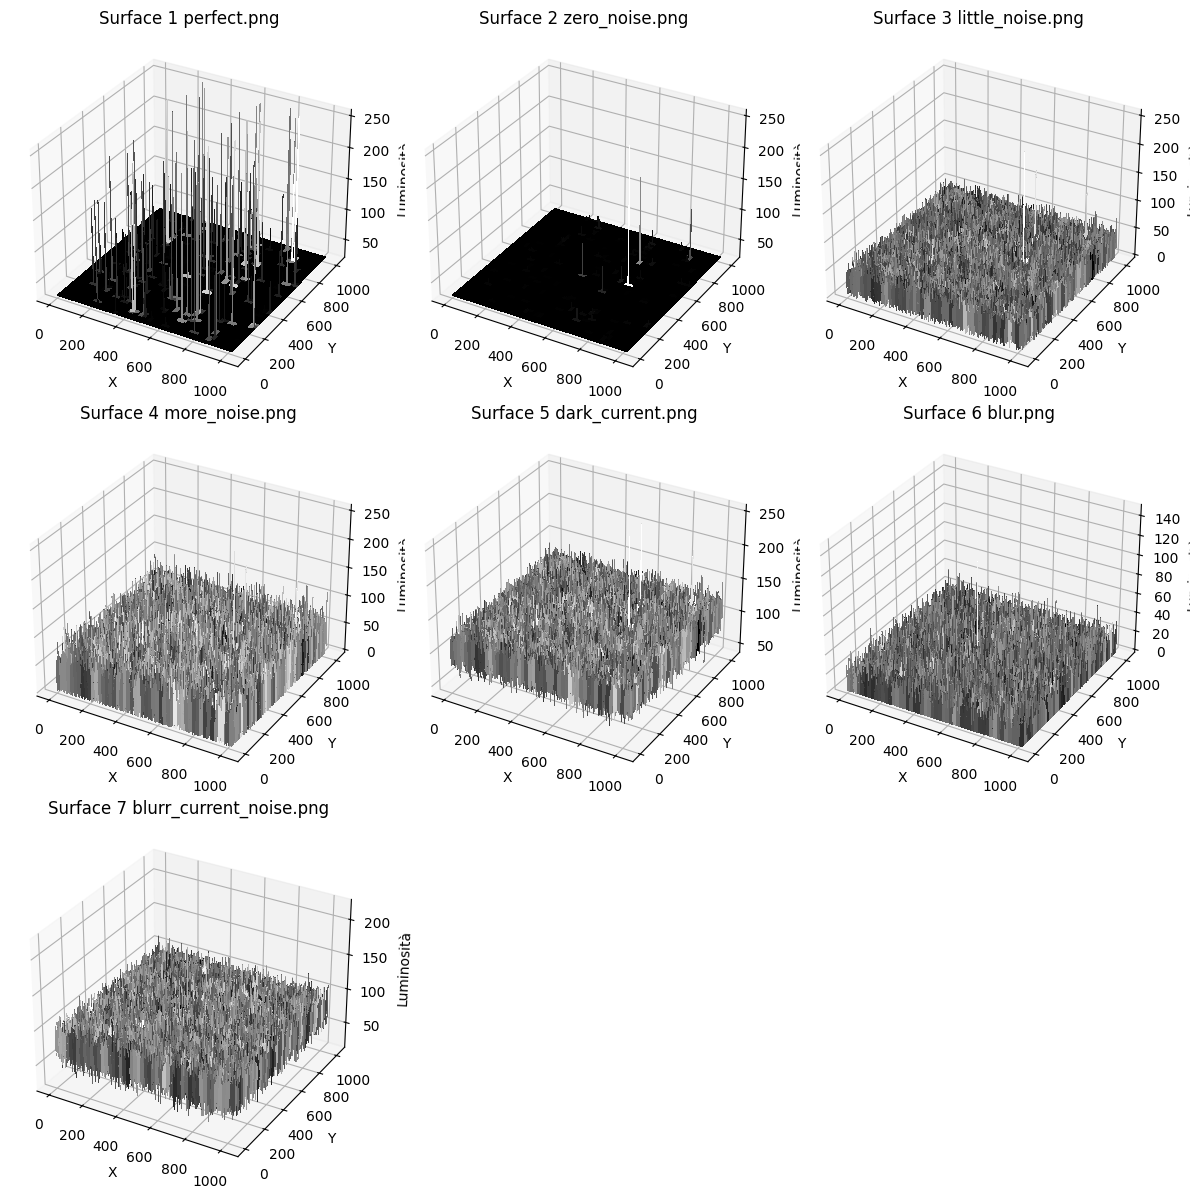

In [16]:
#salvando già i greyscale 
greyscales = []

cols = 3
rows = math.ceil(len(files) / cols)

fig = plt.figure(figsize=(12, 4 * rows))

plot_index = 1  # posizione del subplot

for i, file in enumerate(files):
    img = cv2.imread(os.path.join(image_path, file))

    if img is None:
        raise FileNotFoundError(f"Image not found or failed to load: {image_path}")
    elif  i == 0:
        continue

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    greyscales.append(gray_img)

    # Ottieni dimensioni
    H, W = gray_img.shape

    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    Z = gray_img

    # Crea subplot 3D nella griglia
    ax = fig.add_subplot(rows, cols, plot_index, projection='3d')
    plot_index += 1

    ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Luminosità')
    ax.set_title(f"Surface {file}")

plt.tight_layout()
plt.show()


As noticible the first two cases, with zero noise, present quite a clear graph of level of grey, from which it is easy to distinguish among the background and the stars.
In this two cases we would only need to set a threshold above which every luminous peak would represent a star.

To set this threshold we can draw a cumulative histogram for grey levels and choose the value from which less and less pixel assume that level of grey

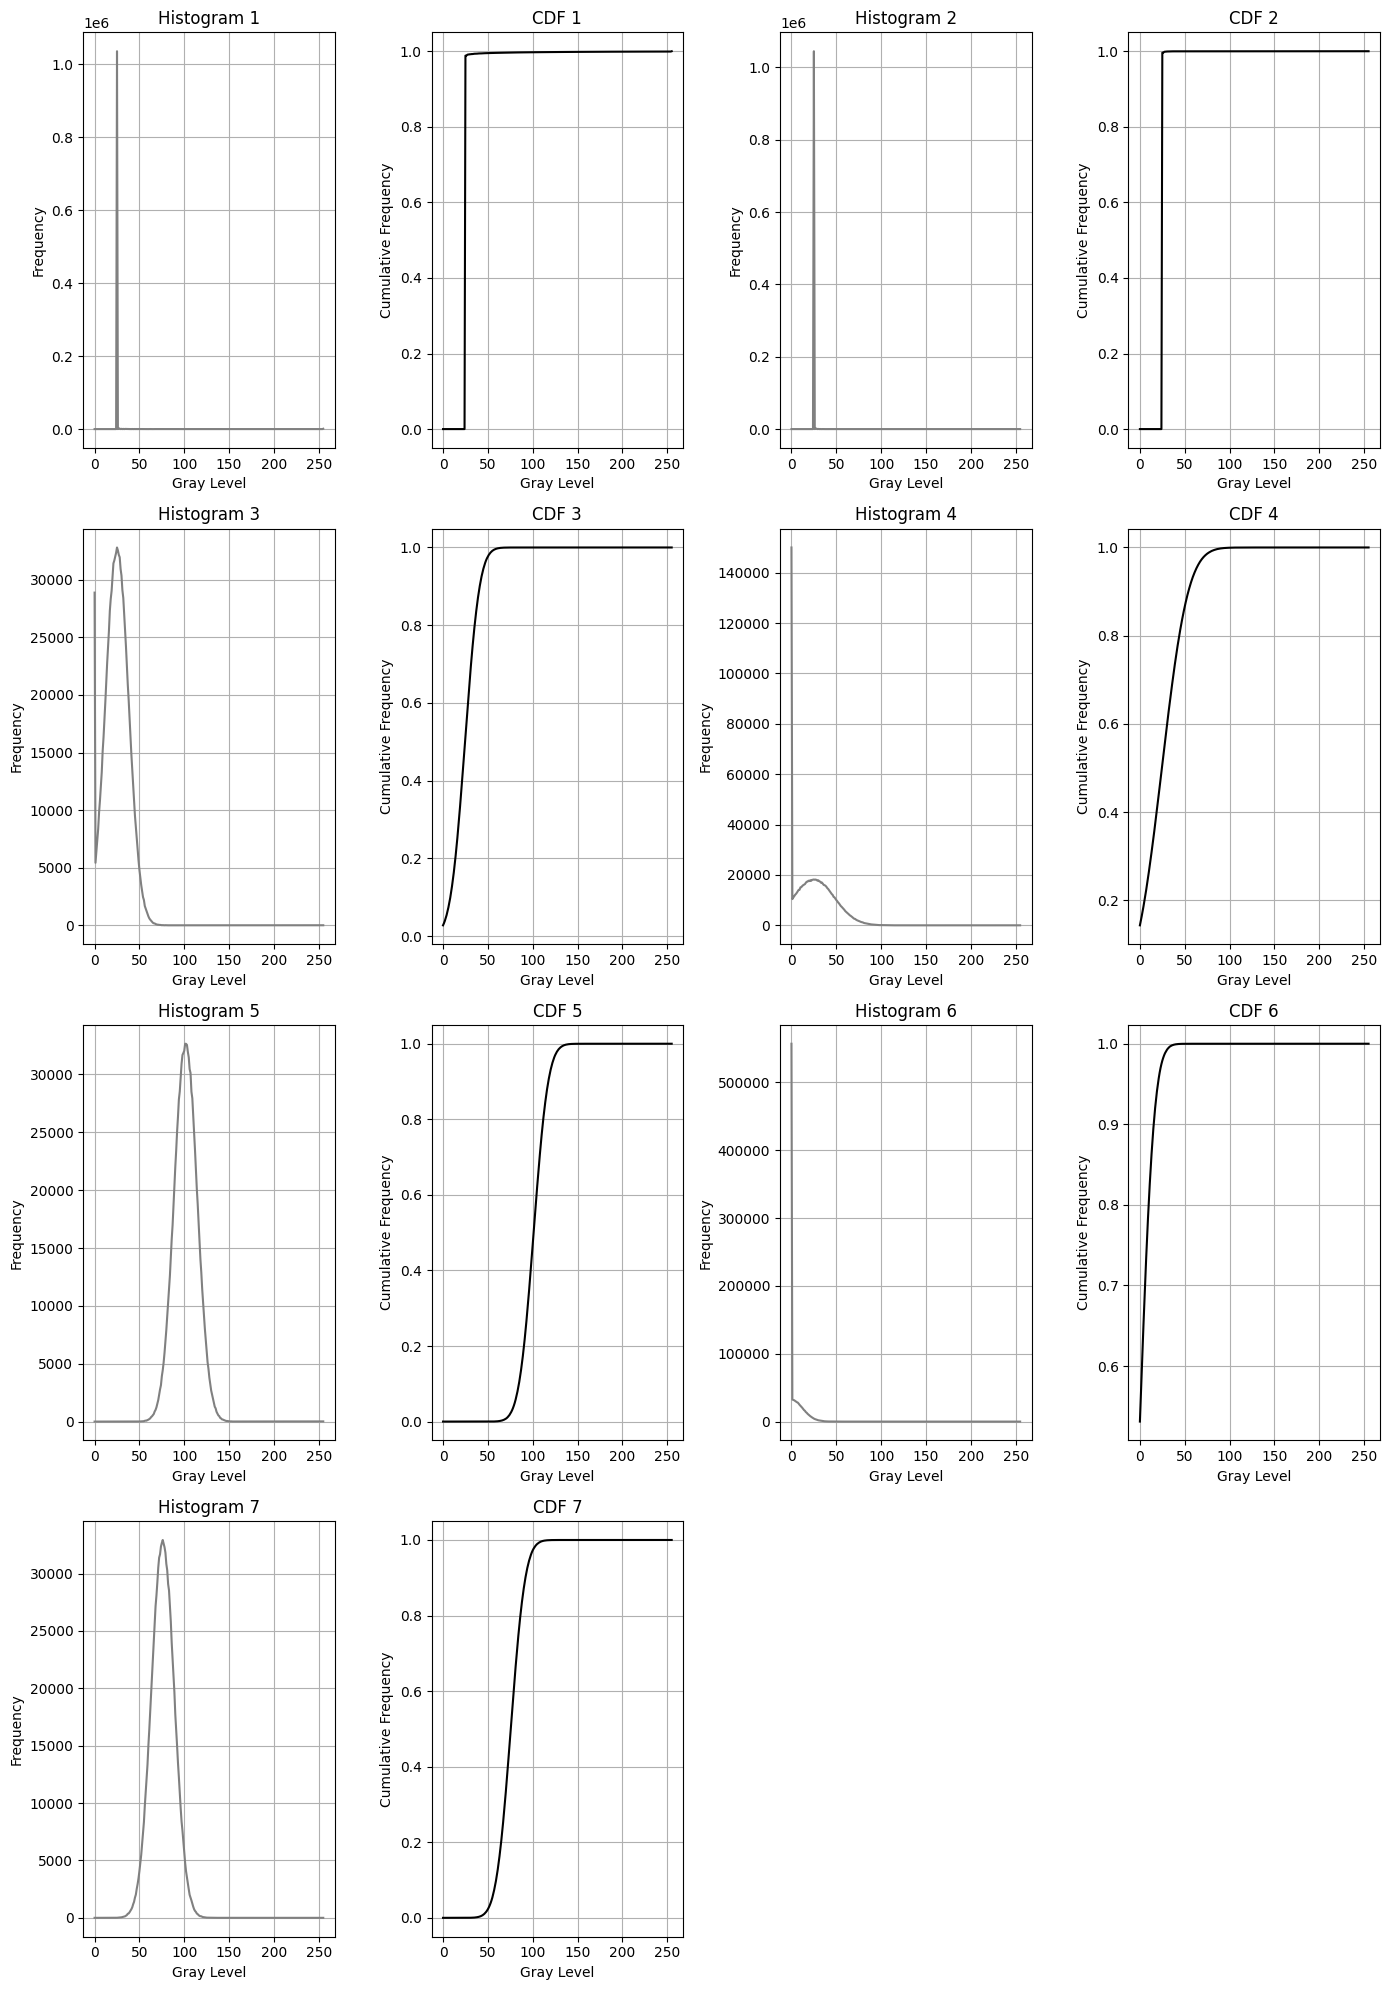

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

cols = 2                      # quante immagini per riga
rows = math.ceil(len(greyscales) / cols)

# Ogni immagine avrà due grafici: histogram + CDF
fig = plt.figure(figsize=(14, 5 * rows))

plot_index = 1

for i, img in enumerate(greyscales):

    # Histogram
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])

    # Cumulative Histogram
    cum_hist = hist.cumsum()
    cum_hist_norm = cum_hist / cum_hist[-1]   # normalizzata (0–1)

    # --- HISTOGRAM ---
    ax1 = fig.add_subplot(rows, cols * 2, plot_index)   # due colonne per immagine
    plot_index += 1

    ax1.plot(hist, color='gray')
    ax1.set_title(f"Histogram {i + 1}")
    ax1.set_xlabel("Gray Level")
    ax1.set_ylabel("Frequency")
    ax1.grid(True)

    # --- CUMULATIVE HISTOGRAM (CDF) ---
    ax2 = fig.add_subplot(rows, cols * 2, plot_index)
    plot_index += 1

    ax2.plot(cum_hist_norm, color='black')
    ax2.set_title(f"CDF {i + 1}")
    ax2.set_xlabel("Gray Level")
    ax2.set_ylabel("Cumulative Frequency")
    ax2.grid(True)

plt.tight_layout()
plt.show()


We know that in star images most of the image is taken by the background, with a very low percentage of pixel representing stars.
For this reason we expect the low level of grey to have the biggest number of pixel.
This is exactly what happens in each graph, with the difference of graphs like the gaussian one that warns about the presence of some kind of noise.
For the moment we start from the basis of our algorithm and we set a threshold where the gray level value has taken more than the 80% of the pixels.
We will after refine this threshold and update resolution for each and every case.

In [18]:
#Detect only stars within certain dimensions
#CONTROLLA SE VERAMENTE UTILE OPPURE ELIMINA
def detect_stars(frame):
    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    stars = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])
            stars.append((cx, cy))
    return np.array(stars)

Rilevati 312 picchi nell'immagine 1
Rilevati 312 picchi nell'immagine 2
Rilevati 9021 picchi nell'immagine 3
Rilevati 8797 picchi nell'immagine 4
Rilevati 9041 picchi nell'immagine 5
Rilevati 9041 picchi nell'immagine 6
Rilevati 9050 picchi nell'immagine 7


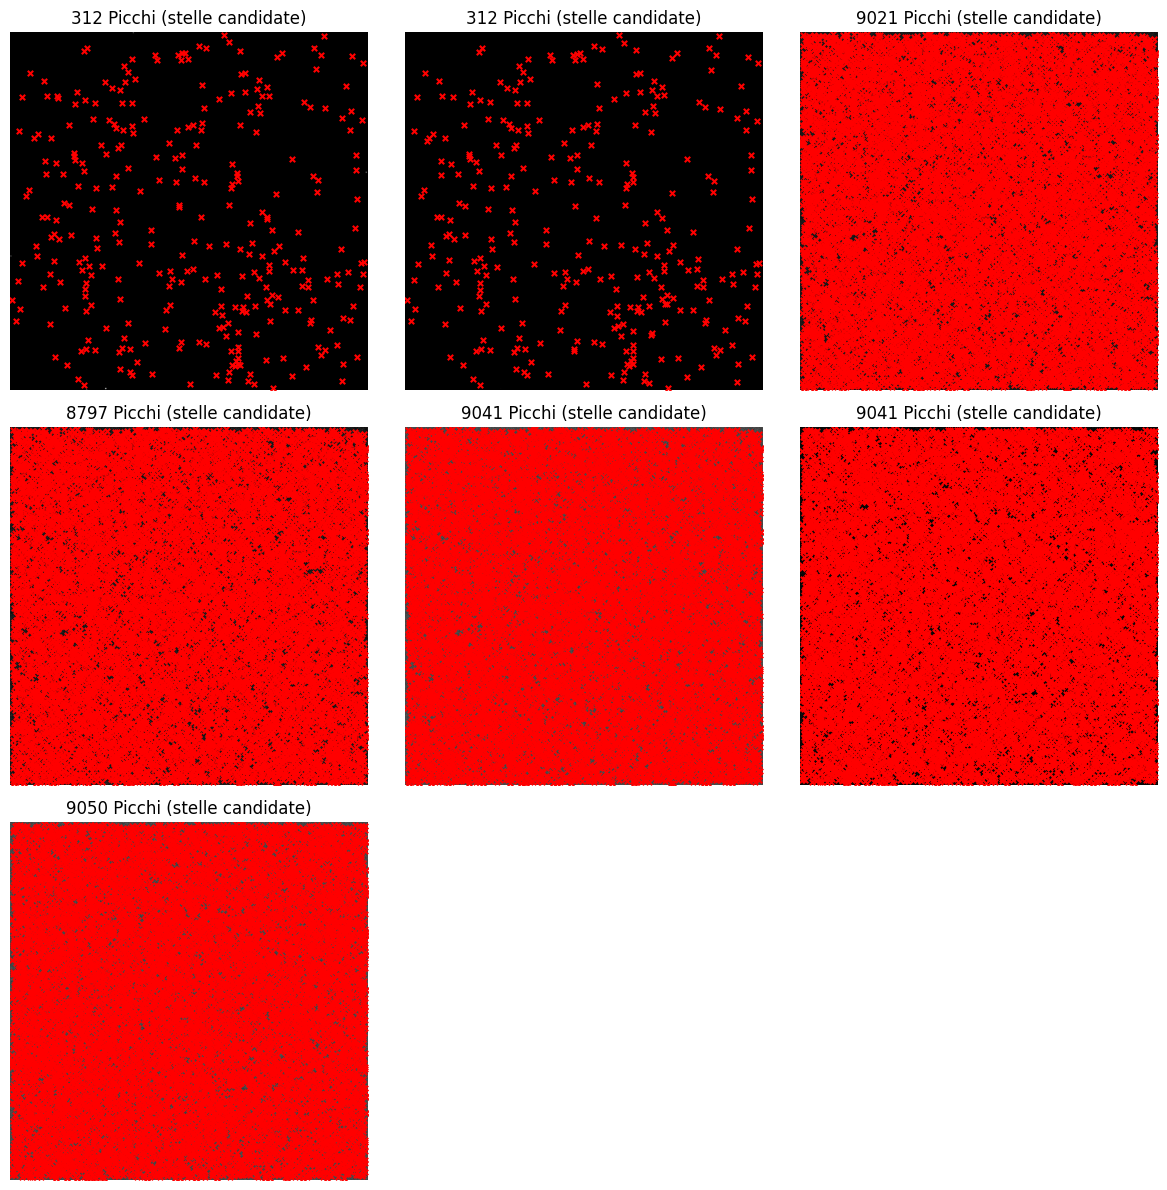

In [19]:
from skimage.feature import peak_local_max

cols = 3
rows = math.ceil(len(greyscales) / cols)

fig = plt.figure(figsize=(12, 4 * rows))

plot_index = 1  # posizione del subplot

for i, img in enumerate(greyscales):

    threshold = np.percentile(img, 80)

    coordinates = peak_local_max(img, min_distance=5, threshold_abs=threshold)
    print(f"Rilevati {len(coordinates)} picchi nell'immagine {i + 1}")

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.scatter(coordinates[:, 1], coordinates[:, 0], c='red',  s=15, marker='x')
    plt.title(f"{len(coordinates)} Picchi (stelle candidate)")
    plt.axis('off')

plt.tight_layout()
plt.show()


As it is is visible using the threshold computed in this way is optimal for the first two cases, but for the rest of the cases we need to add some more information in order to create new conditions in the algorithm.

Let's focus on the images 3, 4, 5, all depicting an increasing noise

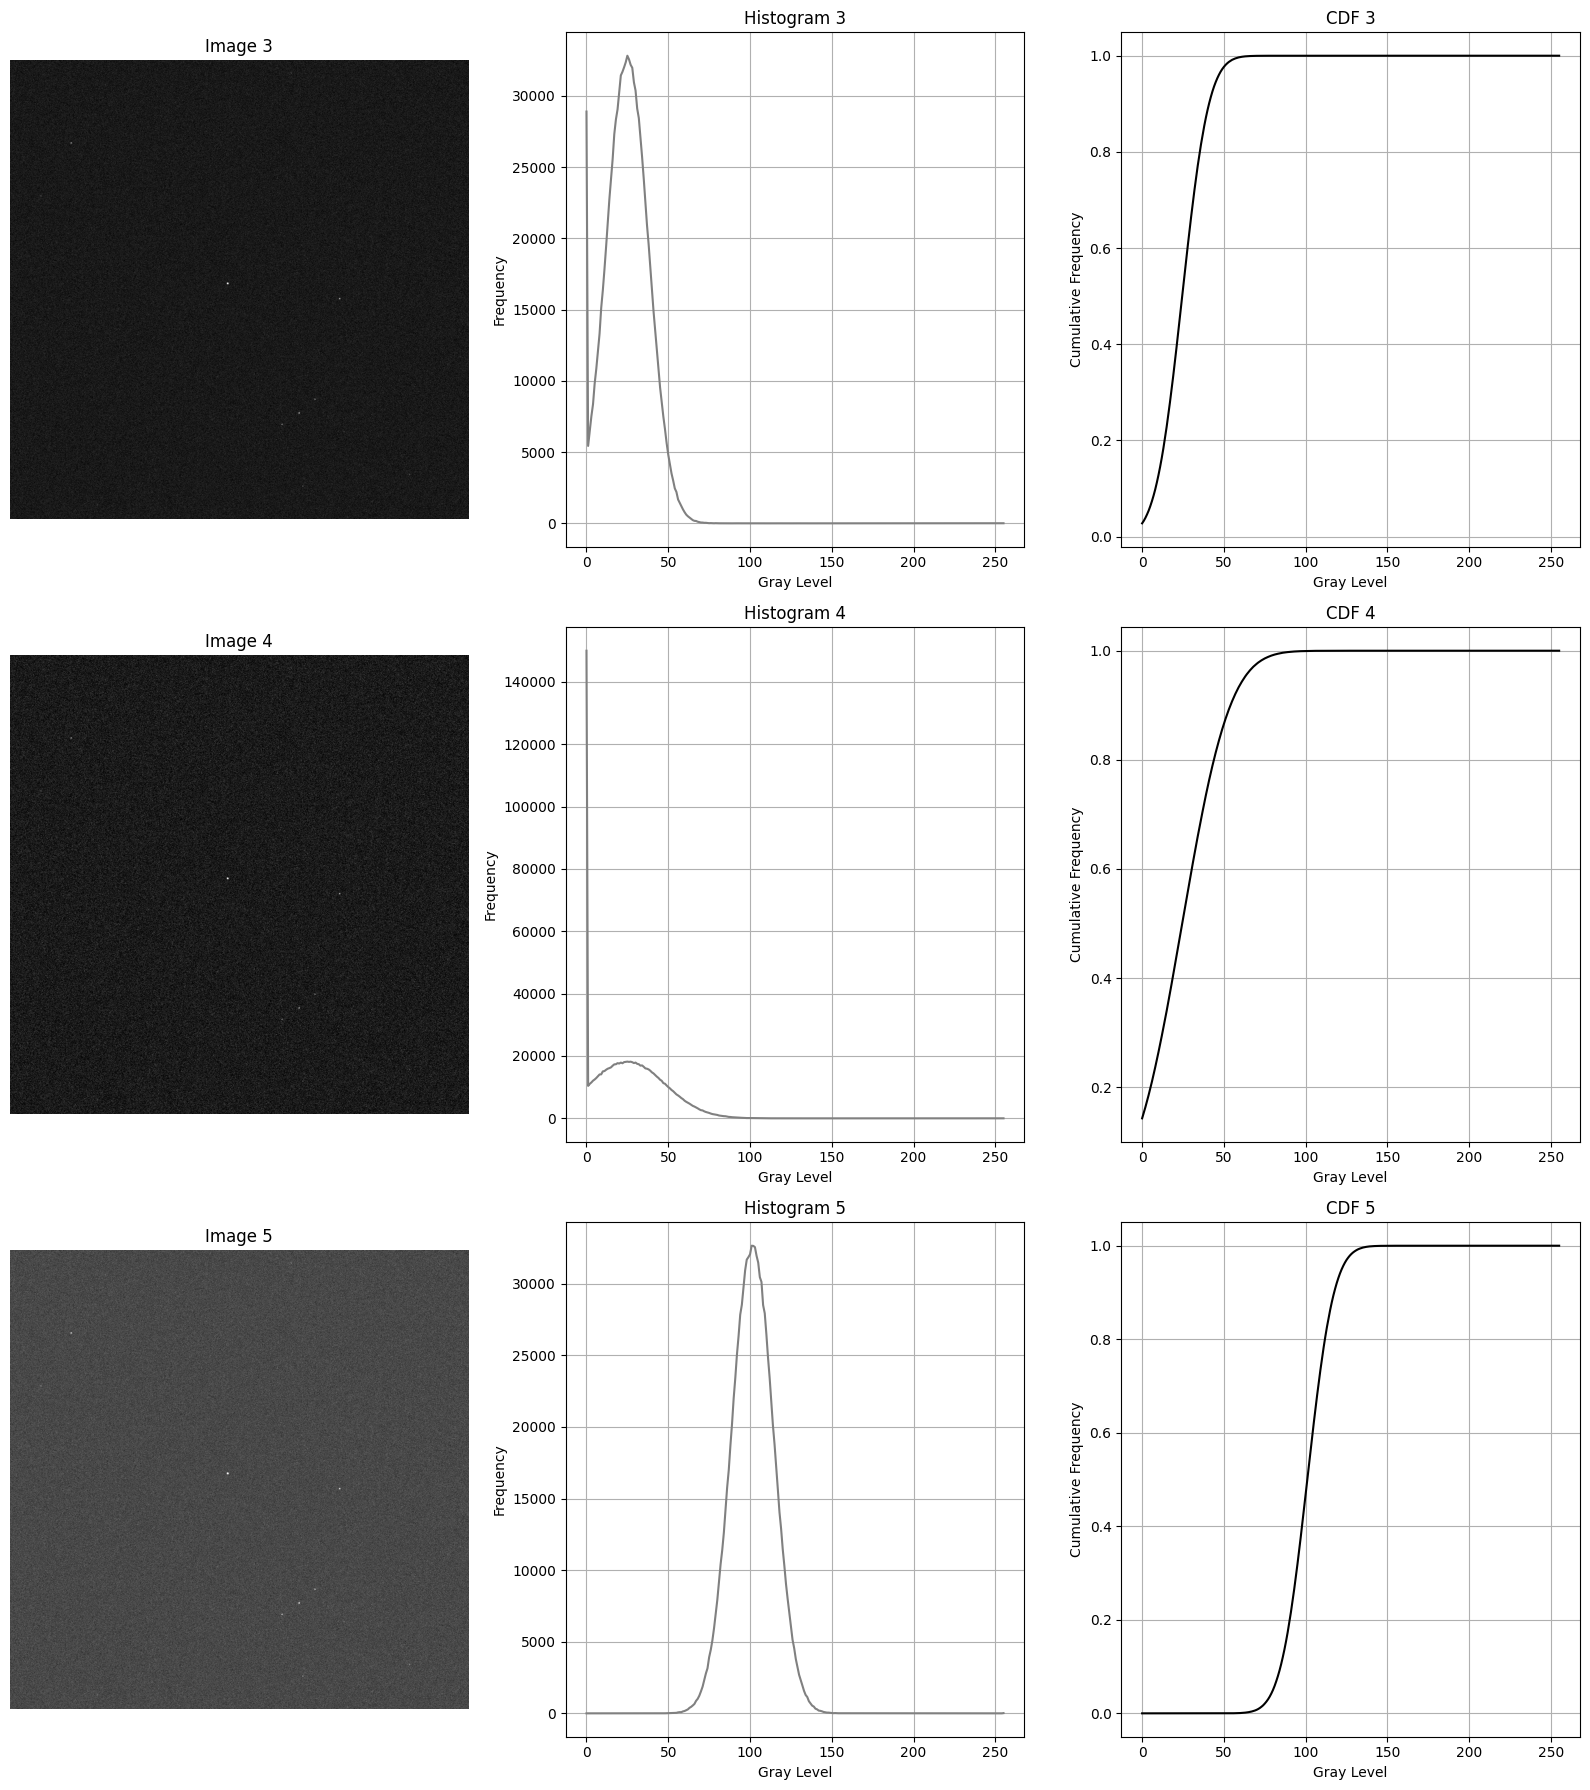

In [20]:
cols = 1                      # quante immagini per riga (non lo usiamo più)
rows = 3                      # 3 immagini → 3 righe

fig = plt.figure(figsize=(16, 6 * rows))
plot_index = 1

for i, img in enumerate(greyscales):

    if i < 2 or i > 4:
        continue  # tieni solo immagini 3,4,5 → 3 immagini totali

    # --- HISTOGRAM ---
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])

    # --- CDF ---
    cum_hist = hist.cumsum()
    cum_hist_norm = cum_hist / cum_hist[-1]

    # --- IMAGE ---
    ax0 = fig.add_subplot(rows, 3, plot_index)
    plot_index += 1
    ax0.imshow(img, cmap='gray')
    ax0.set_title(f"Image {i + 1}")
    ax0.axis('off')

    # --- HISTOGRAM ---
    ax1 = fig.add_subplot(rows, 3, plot_index)
    plot_index += 1
    ax1.plot(hist, color='gray')
    ax1.set_title(f"Histogram {i + 1}")
    ax1.set_xlabel("Gray Level")
    ax1.set_ylabel("Frequency")
    ax1.grid(True)

    # --- CDF ---
    ax2 = fig.add_subplot(rows, 3, plot_index)
    plot_index += 1
    ax2.plot(cum_hist_norm, color='black')
    ax2.set_title(f"CDF {i + 1}")
    ax2.set_xlabel("Gray Level")
    ax2.set_ylabel("Cumulative Frequency")
    ax2.grid(True)

plt.tight_layout()
plt.show()


We can see that in the three pictures above the noise is increasing and extending in the shades of grey.
If in the first case, the histogram reveals a peak of the noise in the small range of 20-40, in the other cases the noise is generally more distributed.
While with the image 3, streching the level of grey in which the density of pixel is limited would bring to better results, in the other two cases, it would amplify also the noise, leading to worse results. For this reason, we will first study the nature and the model describing the noise, to then stretch the grey levels of the denoised image. 


In a denoised image we would have an histogram representing a very strict peak in between the values 0 and 40, which is more or less the grey level of the background. In our case, we have experimented with completely denoised pictures with a background peak around the 25-26 value. We will start from this information to compute the model of the noise

We have four kind of noise in our images:
- The Read/Electrical noise(Gaussian): Widens the histogram around the values of the background
- The Shot noise(Poisson): Given by the light of the stars, it is very small and affects only the pixels near the stars
- The Dark Current noise (Exponential/Poisson): Distributed along the whole image and generated by the fact that each pixel generates a small difference of dark current
- The Quantization noise: here negligible

Because the shot and the quantization noise are negligible in our images, we can say that the image composition is structured in the following way:

Image = Background + ReadNoise + DarkNoise + Stars

Where Background≈25−26, ReadNoise ∼N(0,σ^2) and DarkNoise is a slow-varying offset.

Let's start by computing the ReadNoise variance

In [21]:
def estimate_sigma(image):
    median_val = np.median(image)
    mad = np.median(np.abs(image - median_val))
    sigma = 1.4826 * mad   # converts MAD to std for Gaussian
    return sigma

In [22]:
img3 = greyscales[2]  # immagine 3 (indice 2)
sigma_est3 = estimate_sigma(img3)
print(f"Estimated noise sigma for image 3: {sigma_est3:.2f}")

img4 = greyscales[3]  # immagine 4 (indice 3)
sigma_est4 = estimate_sigma(img4)
print(f"Estimated noise sigma for image 4: {sigma_est4:.2f}")

img5 = greyscales[4]  # immagine 5 (indice 4)
sigma_est5 = estimate_sigma(img5)
print(f"Estimated noise sigma for image 5: {sigma_est5:.2f}")

Estimated noise sigma for image 3: 13.34
Estimated noise sigma for image 4: 23.72
Estimated noise sigma for image 5: 13.34


Even though it might sound strange that for two very different kind of images we have two similar values in variance, we have to better look at the histogram distribution. While the gaussian is moved to the left side, its "amplitude" remains quite similar. For the image4 instead, the gaussian is quite wider even though it stays shorter.

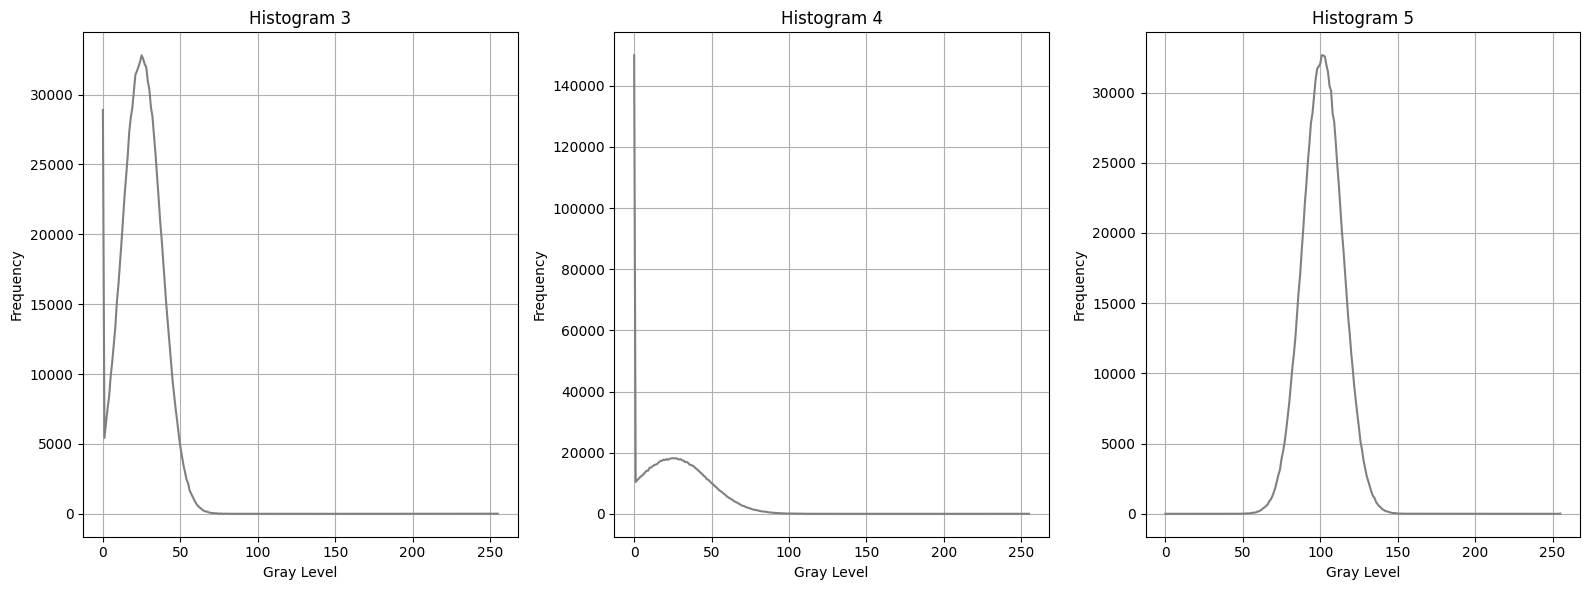

In [23]:
cols = 3                      
rows = 1                     

fig = plt.figure(figsize=(16, 6 * rows))
plot_index = 1

for i, img in enumerate(greyscales):

    if i < 2 or i > 4:
        continue  # tieni solo immagini 3,4,5 → 3 immagini totali

    # --- HISTOGRAM ---
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])

    # --- HISTOGRAM ---
    ax1 = fig.add_subplot(rows, 3, plot_index)
    plot_index += 1
    ax1.plot(hist, color='gray')
    ax1.set_title(f"Histogram {i + 1}")
    ax1.set_xlabel("Gray Level")
    ax1.set_ylabel("Frequency")
    ax1.grid(True)

plt.tight_layout()
plt.show()


Now, we have said that we have some gaussian noise, but then what are the high peak at the very low level in the first two histogram? and how should we work with them?
This peaks are given by the clipping. Clipping occurs when preprocessing produces negative pixel values, which are forced to 0 in the digital representation. This creates an artificial spike at low intensities (0-10 range) but it does not represent physical noise, so we can ignore it when estimating the background.


What we need to do now is to align the peak of the gaussian to where the denoised background peak is located, which is around the value of 25 value.

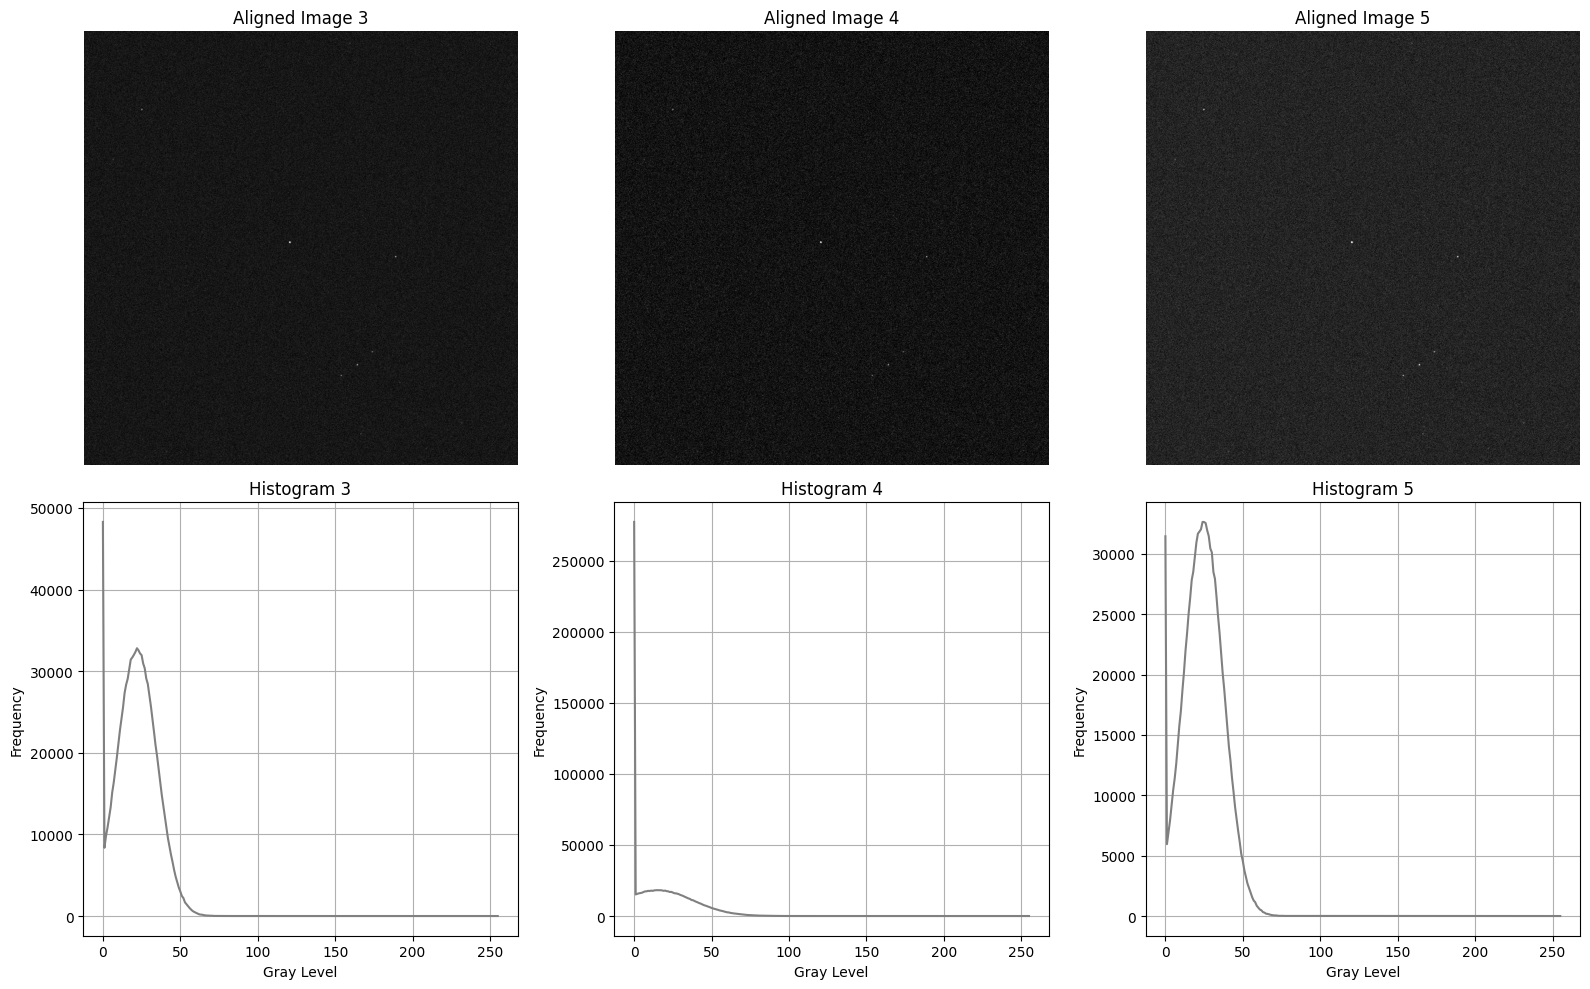

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------
# 1 — SAFE RANGE
# -----------------------
safe_lower = 10

img3_safe = img3[(img3 >= safe_lower)]
img4_safe = img4[(img4 >= safe_lower)]
img5_safe = img5[(img5 >= safe_lower)]

# -----------------------
# 2 — GAUSSIAN FIT
# -----------------------
mu3, sigma3 = norm.fit(img3_safe)
mu4, sigma4 = norm.fit(img4_safe)
mu5, sigma5 = norm.fit(img5_safe)

denoised_peak = 25.5

delta3 = denoised_peak - mu3
delta4 = denoised_peak - mu4
delta5 = denoised_peak - mu5

# -----------------------
# 3 — ALIGN IMAGES
# -----------------------
img3_aligned = np.clip(img3 + delta3, 0, 255)
img4_aligned = np.clip(img4 + delta4, 0, 255)
img5_aligned = np.clip(img5 + delta5, 0, 255)

aligned_images = [img3_aligned, img4_aligned, img5_aligned]
titles = ["Aligned Image 3", "Aligned Image 4", "Aligned Image 5"]

# -----------------------
# 4 — COMPUTE HISTOGRAMS
# -----------------------
histograms = [
    np.histogram(img3_aligned.flatten(), bins=256, range=[0, 256])[0],
    np.histogram(img4_aligned.flatten(), bins=256, range=[0, 256])[0],
    np.histogram(img5_aligned.flatten(), bins=256, range=[0, 256])[0]
]

# -----------------------
# 5 — PLOT 2 ROWS: IMAGES + HISTOGRAMS
# -----------------------
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Row 1: Images ---
for i in range(3):
    axes[0, i].imshow(aligned_images[i], cmap='gray')
    axes[0, i].set_title(titles[i])
    axes[0, i].axis('off')

# --- Row 2: Histograms ---
for i in range(3):
    axes[1, i].plot(histograms[i], color='gray')
    axes[1, i].set_title(f"Histogram {i+3}")
    axes[1, i].set_xlabel("Gray Level")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()


The next step is to make the gaussian variance smaller and smaller in order to reduce the noise. To do this we are going to use the Wavelet thresholding, which means that we are going to shrink the small coefficients in detail bands

We use the soft thresholding , in order to preserve the stars' large coefficients

$$
c' =
\begin{cases}
0, & \text{if } |c| < T \\
c - T \cdot \operatorname{sign}(c), & \text{if } |c| \ge T
\end{cases}
$$

For the Gaussian noise we can simply choose a threshold of 

$$
T = 3\sigma
$$

In [25]:
!pip install PyWavelets


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\anjel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
import pywt
import numpy as np

def wavelet_denoise(img, sigma, wave='db2', level=3, k=3):
    # Wavelet decomposition
    coeffs = pywt.wavedec2(img, wave, level=level)

    # Threshold based on noise
    T = k * sigma

    # Process detail coefficients (skip approximation coeffs[0])
    coeffs_thresh = [coeffs[0]]  # keep the approximation untouched

    for detail_level in coeffs[1:]:
        cH, cV, cD = detail_level
        cH = pywt.threshold(cH, T, mode='soft')
        cV = pywt.threshold(cV, T, mode='soft')
        cD = pywt.threshold(cD, T, mode='soft')
        coeffs_thresh.append((cH, cV, cD))

    # Reconstruct denoised image
    denoised = pywt.waverec2(coeffs_thresh, wave)
    return np.clip(denoised, 0, 255).astype(np.uint8)


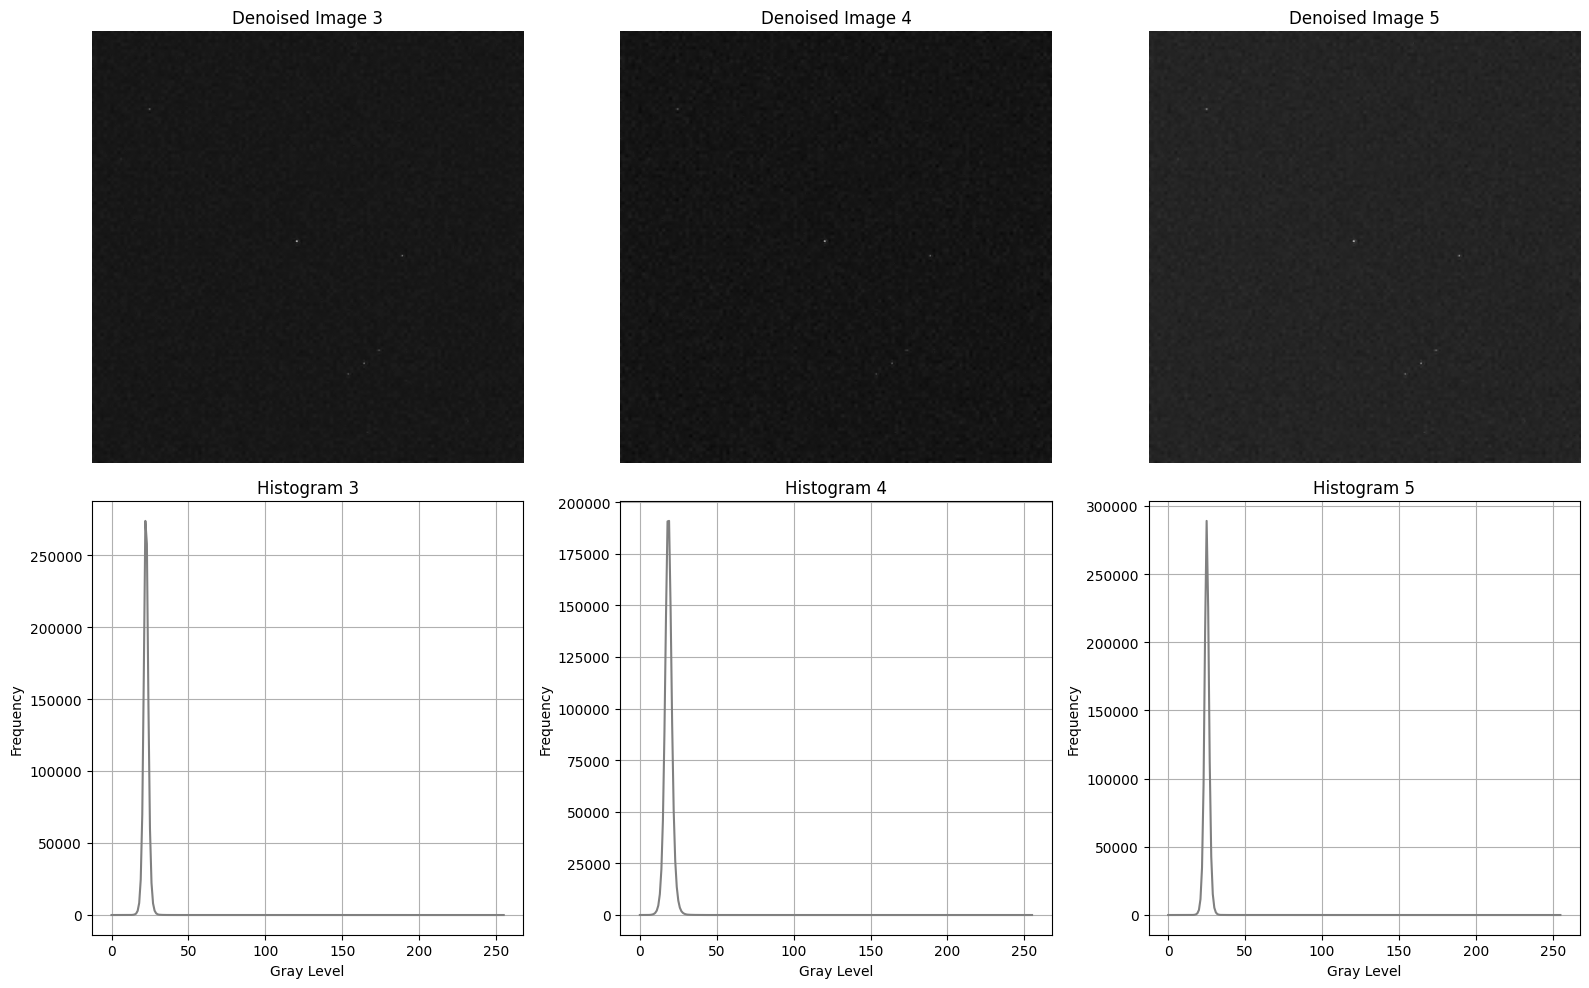

In [27]:
denoised_img3 = wavelet_denoise(img3_aligned, sigma3)
denoised_img4 = wavelet_denoise(img4_aligned, sigma4)
denoised_img5 = wavelet_denoise(img5_aligned, sigma5)

denoised_images = [denoised_img3, denoised_img4, denoised_img5]
titles = ["Denoised Image 3", "Denoised Image 4", "Denoised Image 5"]

# -----------------------
# 4 — COMPUTE HISTOGRAMS
# -----------------------
histograms = [
    np.histogram(denoised_img3.flatten(), bins=256, range=[0, 256])[0],
    np.histogram(denoised_img4.flatten(), bins=256, range=[0, 256])[0],
    np.histogram(denoised_img5.flatten(), bins=256, range=[0, 256])[0]
]

# -----------------------
# 5 — PLOT 2 ROWS: IMAGES + HISTOGRAMS
# -----------------------
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Row 1: Images ---
for i in range(3):
    axes[0, i].imshow(denoised_images[i], cmap='gray')
    axes[0, i].set_title(titles[i])
    axes[0, i].axis('off')

# --- Row 2: Histograms ---
for i in range(3):
    axes[1, i].plot(histograms[i], color='gray')
    axes[1, i].set_title(f"Histogram {i+3}")
    axes[1, i].set_xlabel("Gray Level")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()


While the gaussians are stricter, also the clipping disappears because tha background alignment deletes the negative values while the wavelet denoising reduces the variance, avoiding the generation of pixel with negative or very low values.

we can now try to use the same way of star detection that we have used previously

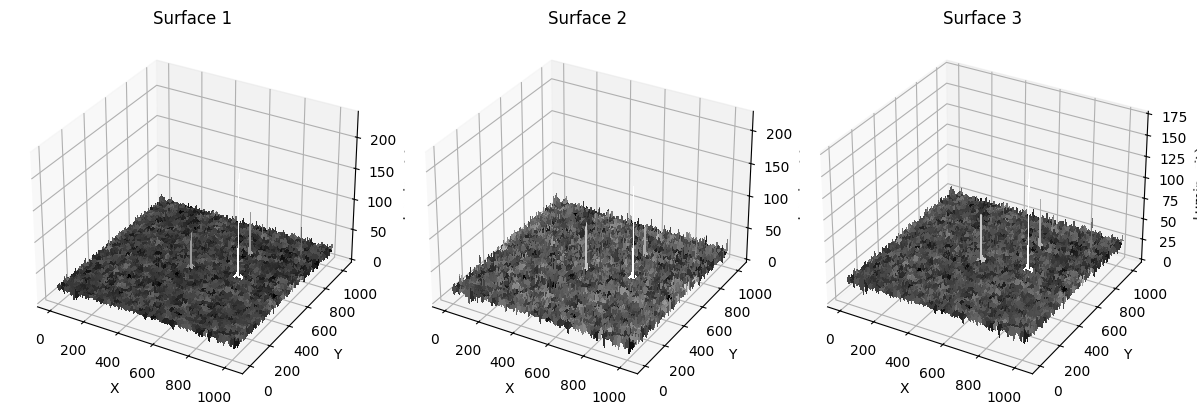

In [28]:
cols = 3
rows = 1

fig = plt.figure(figsize=(12, 4 * rows))

plot_index = 1  # posizione del subplot

for i, img in enumerate(denoised_images):


    # Ottieni dimensioni
    H, W = img.shape

    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    Z = img

    # Crea subplot 3D nella griglia
    ax = fig.add_subplot(rows, cols, plot_index, projection='3d')
    plot_index += 1

    ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Luminosità')
    ax.set_title(f"Surface {i +1}")

plt.tight_layout()
plt.show()


In [29]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter

def enhance_stars(img, sigma=1.5):
    """
    Enhances star visibility via Gaussian PSF matched filtering.
    sigma ~ PSF width of real stars.
    """
    return gaussian_filter(img, sigma=sigma)


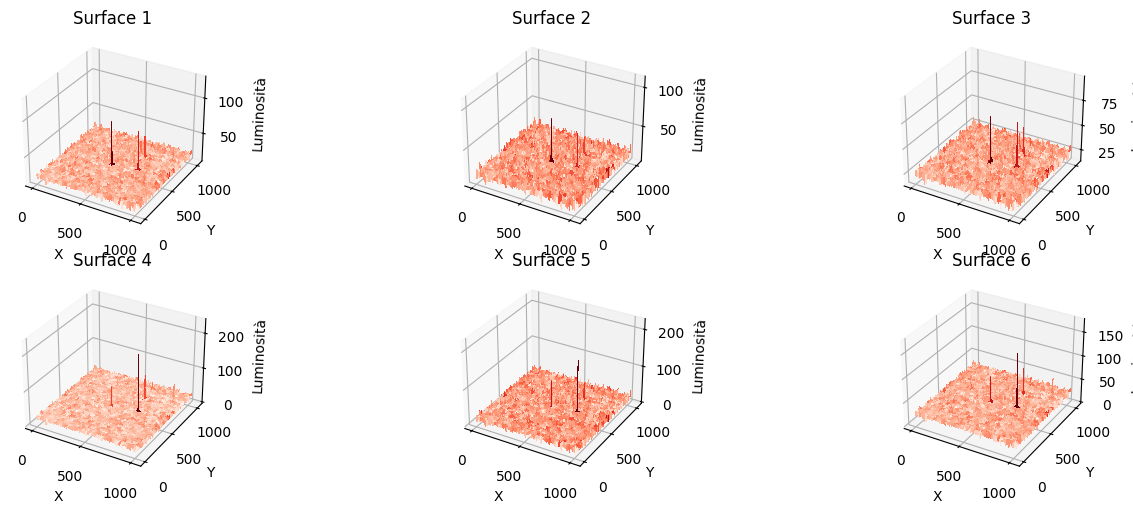

In [30]:
enh3 = enhance_stars(denoised_img3)
enh4 = enhance_stars(denoised_img4)
enh5 = enhance_stars(denoised_img5)

enhanced_images = [enh3, enh4, enh5, denoised_img3, denoised_img4, denoised_img5]
# enhanced_images = [img3, img4, img5]

fig = plt.figure(figsize=(15, 5))

for i, img in enumerate(enhanced_images):

    # Ottieni dimensioni
    H, W = img.shape

    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    Z = img

    # Crea subplot 3D nella griglia
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    ax.plot_surface(X, Y, Z, cmap='Reds', linewidth=0, antialiased=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Luminosità')
    ax.set_title(f"Surface {i +1}")

plt.tight_layout()
plt.show()




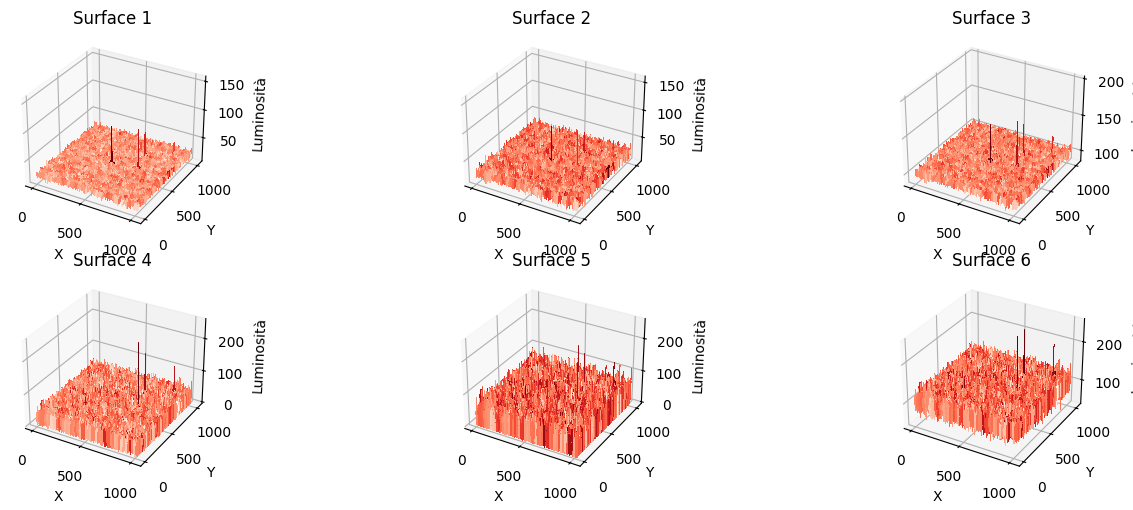

In [31]:
enh3 = enhance_stars(img3)
enh4 = enhance_stars(img4)
enh5 = enhance_stars(img5)

enhanced_images = [enh3, enh4, enh5, img3, img4, img5]
# enhanced_images = [img3, img4, img5]

fig = plt.figure(figsize=(15, 5))

for i, img in enumerate(enhanced_images):

    # Ottieni dimensioni
    H, W = img.shape

    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    Z = img

    # Crea subplot 3D nella griglia
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    ax.plot_surface(X, Y, Z, cmap='Reds', linewidth=0, antialiased=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Luminosità')
    ax.set_title(f"Surface {i +1}")

plt.tight_layout()
plt.show()




In [32]:
def detect_stars_nested_base(img, A_size=3, B_size=7, th_mean=2, th_std=1):
    rA = A_size // 2
    rB = B_size // 2

    H, W = img.shape
    stars = []

    for y in range(rB, H - rB):
        for x in range(rB, W - rB):

            A = img[y - rA : y + rA + 1, x - rA : x + rA + 1]
            B = img[y - rB : y + rB + 1, x - rB : x + rB + 1]

            center = img[y, x]

            # Condition 1: center is max of A
            if center != np.max(A):
                continue

            mean_A = np.mean(A)
            mean_B = np.mean(B)
            if mean_A <= mean_B + th_mean:
                continue

            var_A = np.var(A)
            var_B = np.var(B)
            if var_A <= var_B + th_std:
                continue

            stars.append((x, y))

    return stars


In [33]:
def detect_stars_multiscale(img, 
                            A_sizes=[3,5,7], 
                            B_sizes=[7,11,15],
                            th_mean=2, th_std=1):
    stars = []
    H, W = img.shape

    # Loop su tutte le scale
    for A_size, B_size in zip(A_sizes, B_sizes):
        rA = A_size // 2
        rB = B_size // 2

        for y in range(rB, H - rB):
            for x in range(rB, W - rB):

                A = img[y-rA:y+rA+1, x-rA:x+rA+1]
                B = img[y-rB:y+rB+1, x-rB:x+rB+1]

                center = img[y, x]

                # Condizione 1: picco locale nell'inner window
                if center != np.max(A):
                    continue

                mean_A, mean_B = np.mean(A), np.mean(B)
                if mean_A <= mean_B + th_mean:
                    continue

                var_A, var_B = np.var(A), np.var(B)
                if var_A <= var_B + th_std:
                    continue

                stars.append((x, y))

    # Rimuovi duplicati (pixel trovati a scale diverse)
    stars = list(set(stars))

    return stars


The multiscale method seems to be the easiest and faster to implement

Rilevati 45 picchi nell'immagine 1


TypeError: list indices must be integers or slices, not tuple

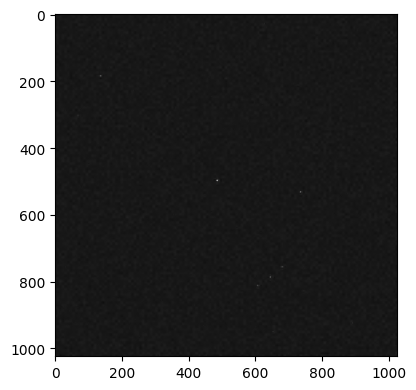

In [41]:
denoised_images = [denoised_img3, denoised_img4, denoised_img5]

cols = 3
rows = 1

fig = plt.figure(figsize=(15, 5))

for i, img in enumerate(denoised_images):
    
    stars_multiscale = detect_stars_multiscale(img)
    print(f"Rilevati {len(stars_multiscale)} picchi nell'immagine {i + 1}")

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    
    # Convert list of tuples to numpy array for proper indexing
    if len(stars_multiscale) > 0:
        stars_array = np.array(stars_multiscale)
        plt.scatter(stars_array[:, 0], stars_array[:, 1], c='red', s=15, marker='x')
    
    plt.title(f"{len(stars_multiscale)} Picchi (stelle candidate)")
    plt.axis('off')


plt.tight_layout()
plt.show()


In [34]:
def detect_stars_nested(img):

    Height, Width = img.shape
    stars = []

    offset_x = 1
    offset_y = 1
    threshold_val = 4  # range di tolleranza rispetto al centro

    for y in range(1, Height - 2):
        for x in range(1, Width - 2):
        
            center = img[y, x]
            A = img[y-offset_y:y+1, x-offset_x:x+1] 

            #esci dal loop prima di uscire dall'immagine
            if y + offset_y >= Height - 1 or x + offset_x >= Width - 1:
                #print(f"Reached image border at ({x},{y}), cannot increase window further")
                #reset window's measures
                offset_x = 1
                offset_y = 1
                continue

            # Estrai i pixel di bordo usando x, y e rispettivi offset 
            top_row    = img[y - 1, x - offset_x : x + 1]
            bottom_row = img[y + offset_y, x - offset_x : x + 1]
            left_col   = img[y - 1 : y + offset_y, x - offset_x]
            right_col  = img[y - 1 : y + offset_y, x + offset_x]

            border_pixels = np.concatenate([top_row, bottom_row, left_col, right_col])

            if np.all(border_pixels < center - threshold_val): #condizione per stella
                #test_if_star(A)

                # print(f"Star detected at ({x},{y}) with offsets ({offset_x},{offset_y})")
                stars.append((x, y))

                #reset window's measures
                offset_x = 1
                offset_y = 1
                continue

            elif np.any(border_pixels > center + threshold_val): #non è una stella
                #reset window's measures
                # print(f"NO STAR at ({x},{y}), all border pixels higher than center")
                offset_x = 1
                offset_y = 1
                continue

            else:

                increased_y = False
                increased_x = False

                # Trova quali pixel hanno valori nel range di soglia
                mask = (border_pixels < center + threshold_val) & (border_pixels > center - threshold_val)
                indices = np.where(mask)[0]         #ritorna gli indici riferiti all'array appiattito border pixels
                for i in indices:
                    if i < offset_x + 2 or (i > 2 * (offset_x + 2) and i < offset_y + 2 + 2 * (offset_x + 2)) :  # top row or left column
                        # print(f"Pixel at index {i} in top or left border, skipping")
                        continue
                    #devo fare in modo che per ogni iterazione quest'operazione si possa fare solo una volta
                    elif i < 2 * (offset_x + 2)  and not increased_y:  # bottom row
                        # print(f"Pixel at index {i} in bottom border, increasing offset_y")
                        offset_y += 1
                        # print(f"Offset_y: {offset_y}")
                        increased_y = True
                    else:  # right column
                        if not increased_x:
                            # print(f"Pixel at index {i} in right border, increasing offset_x")
                            offset_x += 1
                            # print(f"Offset_x: {offset_x}")
                            increased_x = True
              
                # print(f"Pixel at ({x},{y}): {len(indices)} border pixels satisfy condition")
                
                continue

    return stars


C:\Users\anjel\AppData\Local\Temp\ipykernel_24752\3367568234.py:32: RuntimeWarning: overflow encountered in scalar subtract
  if np.all(border_pixels < center - threshold_val): #condizione per stella


Rilevate 293 stelle nell'immagine 3


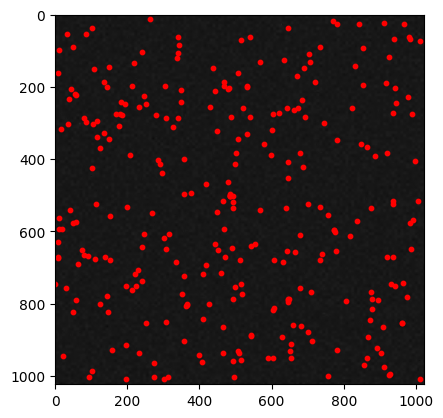

In [35]:
stars3 = detect_stars_nested(denoised_img3)
print(f"Rilevate {len(stars3)} stelle nell'immagine 3")
plt.imshow(denoised_img3, cmap='gray')
for x, y in stars3:
    plt.scatter(x, y, c='red', s=10)
plt.show()

C:\Users\anjel\AppData\Local\Temp\ipykernel_24752\3367568234.py:32: RuntimeWarning: overflow encountered in scalar subtract
  if np.all(border_pixels < center - threshold_val): #condizione per stella


Rilevate 745 stelle nell'immagine 4


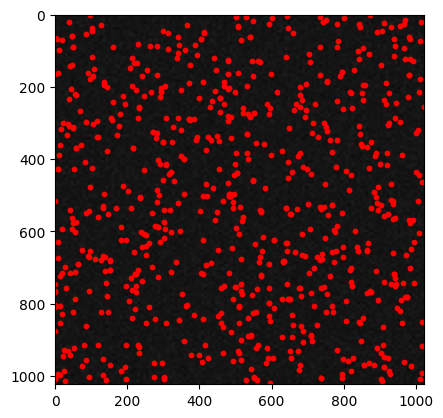

In [36]:
stars4 = detect_stars_nested(denoised_img4)
print(f"Rilevate {len(stars4)} stelle nell'immagine 4")
plt.imshow(denoised_img4, cmap='gray')
for x, y in stars4:
    plt.scatter(x, y, c='red', s=10)
plt.show()

C:\Users\anjel\AppData\Local\Temp\ipykernel_24752\3367568234.py:32: RuntimeWarning: overflow encountered in scalar subtract
  if np.all(border_pixels < center - threshold_val): #condizione per stella


Rilevate 49 stelle nell'immagine 5


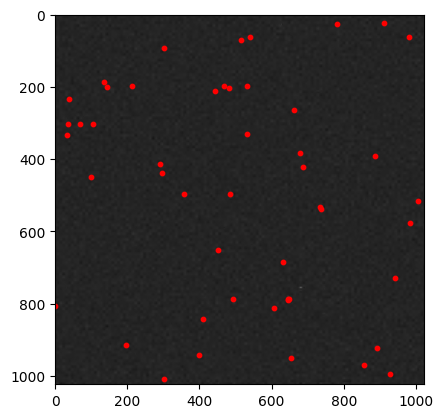

In [37]:
stars5 = detect_stars_nested(denoised_img5)
print(f"Rilevate {len(stars5)} stelle nell'immagine 5")
plt.imshow(denoised_img5, cmap='gray')
for x, y in stars5:
    plt.scatter(x, y, c='red', s=10)
plt.show()

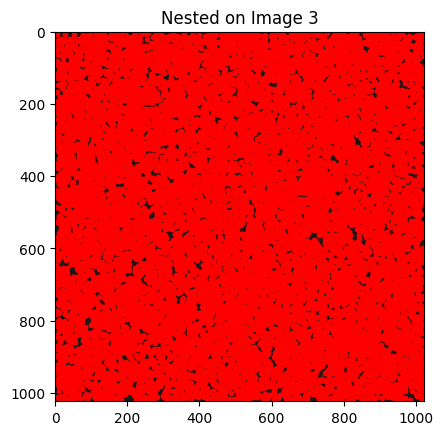

Rilevate 13956 stelle nell'immagine 3


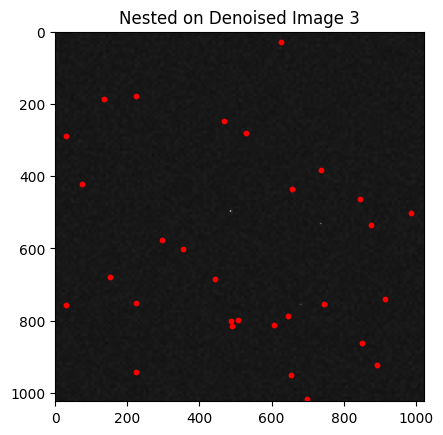

Rilevate 30 stelle nell'immagine 3


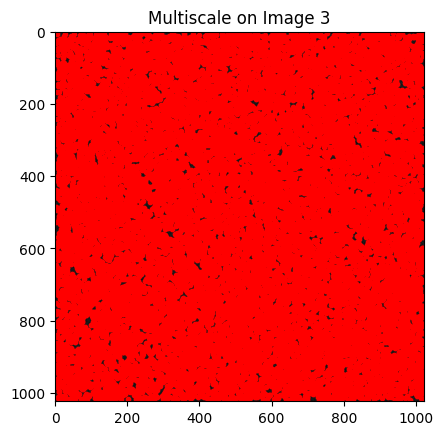

Rilevate 16163 stelle nell'immagine 3


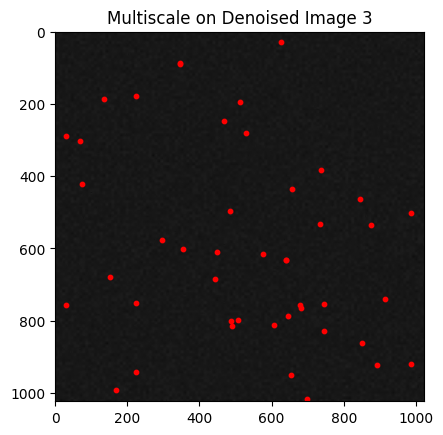

Rilevate 45 stelle nell'immagine 3


In [38]:
stars3 = detect_stars_nested_base(img3)

plt.imshow(img3, cmap='gray')
for x, y in stars3:
    plt.scatter(x, y, c='red', s=10)
plt.title("Nested on Image 3")
plt.show()
print(f"Rilevate {len(stars3)} stelle nell'immagine 3")

stars3_denoised = detect_stars_nested_base(denoised_img3)

plt.imshow(denoised_img3, cmap='gray')
for x, y in stars3_denoised:
    plt.scatter(x, y, c='red', s=10)
plt.title("Nested on Denoised Image 3")
plt.show()
print(f"Rilevate {len(stars3_denoised)} stelle nell'immagine 3")


stars3_multiscale = detect_stars_multiscale(img3)

plt.imshow(img3, cmap='gray')
for x, y in stars3_multiscale:
    plt.scatter(x, y, c='red', s=10)
plt.title("Multiscale on Image 3")
plt.show()
print(f"Rilevate {len(stars3_multiscale)} stelle nell'immagine 3")

stars3_multiscale_denoised = detect_stars_multiscale(denoised_img3)

plt.imshow(denoised_img3, cmap='gray')
for x, y in stars3_multiscale_denoised:
    plt.scatter(x, y, c='red', s=10)
plt.title("Multiscale on Denoised Image 3")
plt.show()
print(f"Rilevate {len(stars3_multiscale_denoised)} stelle nell'immagine 3")



In [39]:
dog3 = multiscale_dog(denoised_img3)
dog4 = multiscale_dog(denoised_img4)
dog5 = multiscale_dog(denoised_img5)

dog_images = [dog3, dog4, dog5]

fig = plt.figure(figsize=(15, 5))

for i, img in enumerate(dog_images):

    # Ottieni dimensioni
    H, W = img.shape

    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    Z = img

    # Crea subplot 3D nella griglia
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    ax.plot_surface(X, Y, Z, cmap='Reds', linewidth=0, antialiased=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Luminosità')
    ax.set_title(f"Surface {i +1}")

plt.tight_layout()
plt.show()



NameError: name 'multiscale_dog' is not defined

In [ ]:
import numpy as np
import cv2

def detect_stars_concentric(img, A_size=3, B_size=7, th_mean=2, th_std=1):
    """
    Star detection basata su finestre concentriche (dal paper).
    
    img: immagine filtrata (float o uint8)
    A_size: dimensione finestra interna (3 o 5)
    B_size: dimensione finestra esterna (7 o 9)
    th_mean: soglia per differenza tra mean_A e mean_B
    th_std: soglia per differenza tra var_A e var_B
    """

    assert B_size > A_size, "B must be larger than A"

    # mezze-finestra
    rA = A_size // 2
    rB = B_size // 2

    H, W = img.shape
    stars = []

    # Scansione immagine
    for y in range(rB, H - rB):
        for x in range(rB, W - rB):

            # Estrai finestre A e B
            A = img[y - rA:y + rA + 1, x - rA:x + rA + 1]
            B = img[y - rB:y + rB + 1, x - rB:x + rB + 1]

            # Punto centrale
            center = img[y, x]

            # --- Condizione 1: Il pixel centrale è il max di A ---
            if center != np.max(A):
                continue

            # --- Calcola statistiche ---
            mean_A = np.mean(A)
            mean_B = np.mean(B)
            var_A = np.var(A)
            var_B = np.var(B)

            # --- Condizione 2: mean_A > mean_B + soglia ---
            if mean_A <= mean_B + th_mean:
                continue

            # --- Condizione 3: var_A > var_B + soglia ---
            if var_A <= var_B + th_std:
                continue

            # Tutte le condizioni superate → stella
            stars.append((x, y))

    return stars


In [ ]:
stars3 = detect_stars_concentric(denoised_img3)
# stars4 = detect_stars_concentric(denoised_img4)
# stars5 = detect_stars_concentric(denoised_img5)

print("Stars Image 3:", len(stars3))
# print("Stars Image 4:", len(stars4))
# print("Stars Image 5:", len(stars5))


Stars Image 3: 30


Background median: 25.0
Noise sigma: 1.4826
Star threshold: 29.4478


Text(0.5, 1.0, 'Star Mask')

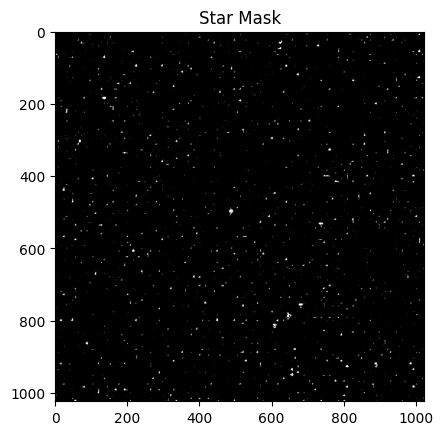

In [ ]:
img_flat = img.flatten().astype(float)

# Stima robusta del background (mediana)
bg_med = np.median(img_flat)

# Stima robusta della sigma dal MAD
mad = np.median(np.abs(img_flat - bg_med))
sigma = 1.4826 * mad

# threshold astronomica
k = 3   # prova 3, 4, 5 per vedere cosa funziona meglio
threshold = bg_med + k * sigma

print("Background median:", bg_med)
print("Noise sigma:", sigma)
print("Star threshold:", threshold)

# maschera delle stelle
stars_mask = img >= threshold

plt.imshow(stars_mask, cmap='gray')
plt.title("Star Mask")


In [ ]:
from skimage.feature import peak_local_max

cols = 3
rows = 1
fig = plt.figure(figsize=(12, 4))

for i, img in enumerate(denoised_images):

    # Estimate background and noise
    mu = np.median(img)
    sigma_new = 1.4826 * np.median(np.abs(img - mu))

    # Statistical threshold
    threshold = mu + 4 * sigma_new

    # Detect stars
    coordinates = peak_local_max(img, 
                                 min_distance=4,
                                 threshold_abs=threshold)
    
    print(f"Rilevati {len(coordinates)} picchi nell'immagine {i + 1}")

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.scatter(coordinates[:, 1], coordinates[:, 0], c='red', s=15, marker='x')
    plt.title(f"{len(coordinates)} stelle rilevate")
    plt.axis('off')

plt.tight_layout()
plt.show()


Numero di picchi rilevati: 327


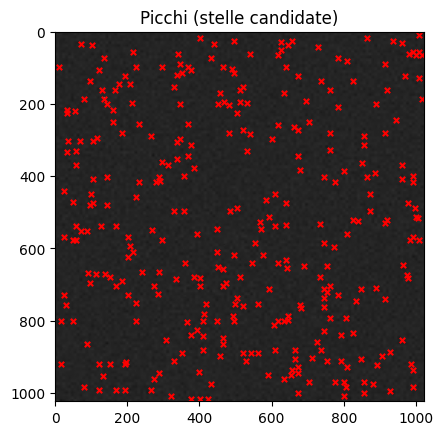

In [ ]:
# Trova i picchi (stelle) sull’immagine grigia
coordinates = peak_local_max(img, min_distance=5, threshold_abs=31)        #perchè? Calcola valori più presenti di luminosità

print("Numero di picchi rilevati:", len(coordinates))

# Visualizza
plt.imshow(img, cmap='gray')
plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r', s=15, marker='x')
plt.title("Picchi (stelle candidate)")
plt.show()
